# Creating the fmrate dataset in another format

In [1]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd
import copy
import sys

from scipy import stats
from numba import njit

In [2]:
sys.path.append('../')

from src import load_data

## Loading root file and preprocessing the data

- We load the root file using uproot and show its contents. We can then obtain a dictionary where keys are some of the TTree names and values are numpy arrays containing the data. **Note that we might only keep a subset of the information**.

In [3]:
data_dict = load_data.load_data_as_dict(root_filename = "../data/fmrate.root",
                                        TTree_features_dict={
                        "fmrate":
                                ["time_since_saa", # saa 
                               "raz",
                               "decz",
                               "rax",
                               "decx",
                               # "obox_mode",
                               "temperature",  # sum
                               "glon", 
                               "glat",
                               "unix_time",  # tunix
                               "fe_cosmic",  # sum
                               "rate",  # fe_rate 12 instead of 25 because energies instead of modules
                               "config",  # new, interested in config=42
                               "is_orbit_up", # new
                               "altitude",
                               "sun",
                               "sun_spot",
                               "B_r",
                               "B_theta",
                               "B_phi"
                               # "crabarf"  # new, bright light, TODO: to better understand
                                # need magnetic field info too.
                                ]})

TTree: fmrate's contents:
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
unix_time            | double                   | AsDtype('>f8')
rate                 | double[12]               | AsDtype("('>f8', (12,))")
glat                 | double                   | AsDtype('>f8')
glon                 | double                   | AsDtype('>f8')
altitude             | double                   | AsDtype('>f8')
temperature          | float                    | AsDtype('>f4')
fe_cosmic            | float                    | AsDtype('>f4')
corrected            | double[1]                | AsDtype("('>f8', (1,))")
correrr              | double[1]                | AsDtype("('>f8', (1,))")
config               | int32_t                  | AsDtype('>i4')
raz                  | double                   | AsDtype('>f8')
decz                 | double                   | AsDtype('>f8')
r

<!--The TTree `B_field` contains information on the magnetic field and is aligned with the data in `t_hk_obox`--->

In [4]:
data_dict.keys()

dict_keys(['time_since_saa', 'raz', 'decz', 'rax', 'decx', 'temperature', 'glon', 'glat', 'unix_time', 'fe_cosmic', 'rate', 'config', 'is_orbit_up', 'altitude', 'sun', 'sun_spot', 'B_r', 'B_theta', 'B_phi'])

In [5]:
# create key, value pair for each dim of "rate" separately. Combine that dictionary with data_dict
data_dict |= dict(zip([f"rate[{i}]" for i in range(data_dict["rate"].shape[1])], data_dict["rate"].T))
# Remove from data_dict, the key "rate"
try:
    del data_dict["rate"]
except:
    pass

<!--- - Create a pandas dataframe containing all the features we selected where we keep only one of the `rate` (e.g first one. We don't have anymore $25$ modules). We no longer have $25$ values for the temperature and `fe_cosmic`. -->
- Create a pandas dataframe containing all the features (and we'll show things just for the first one later on. We no longer have $25$ values for the $25$ modules, we have $12$ values related to the "energy"). We also no longer have $25$ values for the temperature and `fe_cosmic`.

In [6]:
i = 0  # rate[i]
# data_df = pd.DataFrame.from_dict(dict((k, v) if k != "rate" else (f"rate[{i}]", v[:, i]) for k, v in data_dict.items()))
data_df = pd.DataFrame.from_dict(data_dict)
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,...,rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.599998,69.831172,41.997769,1.483525e+09,8323.0,...,9.175346,2.398795,0.000000,144902.177530,45712.324384,13845.953080,8356.903924,2438.513754,239474.841087,11744.694832
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.700001,74.831447,42.486682,1.483526e+09,7893.0,...,12.970488,0.977676,0.000000,153318.962241,48581.165475,14829.628152,8883.639889,2635.849803,253521.561985,12586.337166
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.799999,79.894200,42.732372,1.483526e+09,8616.0,...,22.955236,6.997275,1.440506,153940.468185,48497.795501,14516.429778,8760.980672,2490.574534,253464.050166,12447.241383
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.900002,84.978480,42.730839,1.483526e+09,7961.0,...,10.679009,0.000000,0.000000,153332.226326,48214.601357,14549.504555,8738.605590,2533.338163,253057.586337,12516.820358
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.000000,90.041732,42.481912,1.483526e+09,7857.0,...,10.958631,1.675759,0.000000,152311.547934,48175.919461,14699.423072,8731.916784,2473.908613,249121.718756,12395.476760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.299999,102.504047,-39.787169,1.489744e+09,19174.0,...,20.845726,0.000000,0.000000,421381.161376,91254.976413,18187.144117,10166.549068,2520.873146,675029.015069,17152.212729
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.299999,107.186486,-40.836773,1.489745e+09,21385.0,...,15.407485,0.498087,0.000000,493352.601640,91960.388522,18408.719222,10437.676092,2687.357262,787895.241321,17259.848070
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.400002,111.848502,-41.645589,1.489745e+09,22211.0,...,19.850554,3.139644,0.000000,381079.484260,80642.260970,19433.904554,10932.724402,2747.667543,648988.657261,17762.022693
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.400002,116.784951,-42.257397,1.489745e+09,23759.0,...,19.554150,1.672301,0.000000,339358.361808,78711.053376,20140.309630,11353.850287,2851.749516,594285.018883,18096.580711


In [7]:
data_df.dtypes

time_since_saa    float64
raz               float64
decz              float64
rax               float64
decx              float64
temperature       float32
glon              float64
glat              float64
unix_time         float64
fe_cosmic         float32
config              int32
is_orbit_up          bool
altitude          float64
sun               float64
sun_spot          float64
B_r               float64
B_theta           float64
B_phi             float64
rate[0]           float64
rate[1]           float64
rate[2]           float64
rate[3]           float64
rate[4]           float64
rate[5]           float64
rate[6]           float64
rate[7]           float64
rate[8]           float64
rate[9]           float64
rate[10]          float64
rate[11]          float64
dtype: object

Let's quickly check if `config` = `42` for all of them

In [8]:
assert np.all(data_df["config"] == 42), "there is at least one config != 42"

In [9]:
# Drop the column config
data_df.drop(columns=["config"], inplace=True)
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,...,rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.599998,69.831172,41.997769,1.483525e+09,8323.0,...,9.175346,2.398795,0.000000,144902.177530,45712.324384,13845.953080,8356.903924,2438.513754,239474.841087,11744.694832
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.700001,74.831447,42.486682,1.483526e+09,7893.0,...,12.970488,0.977676,0.000000,153318.962241,48581.165475,14829.628152,8883.639889,2635.849803,253521.561985,12586.337166
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.799999,79.894200,42.732372,1.483526e+09,8616.0,...,22.955236,6.997275,1.440506,153940.468185,48497.795501,14516.429778,8760.980672,2490.574534,253464.050166,12447.241383
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.900002,84.978480,42.730839,1.483526e+09,7961.0,...,10.679009,0.000000,0.000000,153332.226326,48214.601357,14549.504555,8738.605590,2533.338163,253057.586337,12516.820358
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.000000,90.041732,42.481912,1.483526e+09,7857.0,...,10.958631,1.675759,0.000000,152311.547934,48175.919461,14699.423072,8731.916784,2473.908613,249121.718756,12395.476760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.299999,102.504047,-39.787169,1.489744e+09,19174.0,...,20.845726,0.000000,0.000000,421381.161376,91254.976413,18187.144117,10166.549068,2520.873146,675029.015069,17152.212729
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.299999,107.186486,-40.836773,1.489745e+09,21385.0,...,15.407485,0.498087,0.000000,493352.601640,91960.388522,18408.719222,10437.676092,2687.357262,787895.241321,17259.848070
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.400002,111.848502,-41.645589,1.489745e+09,22211.0,...,19.850554,3.139644,0.000000,381079.484260,80642.260970,19433.904554,10932.724402,2747.667543,648988.657261,17762.022693
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.400002,116.784951,-42.257397,1.489745e+09,23759.0,...,19.554150,1.672301,0.000000,339358.361808,78711.053376,20140.309630,11353.850287,2851.749516,594285.018883,18096.580711


In [10]:
tunix_name, target_name = 'unix_time', f'rate[{i}]'

**Need for normalizing some features ? Probably, we'll do it later and after splitting the data (otherwise data leakage)!!**

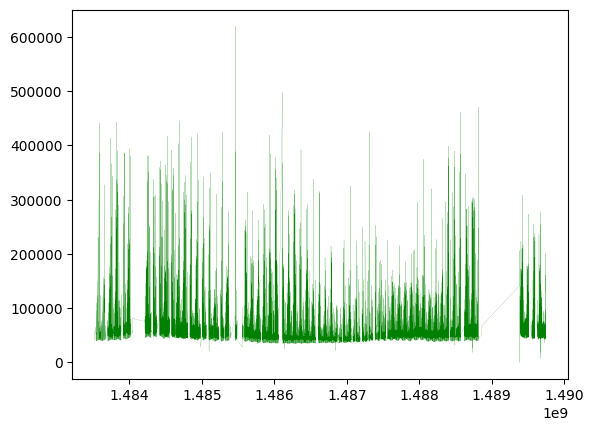

In [11]:
plt.plot(data_df[tunix_name], data_df[target_name], 'g', linewidth=0.1)
plt.show()

In [12]:
data_df[tunix_name][:10]-data_df[tunix_name][:10].min()

0      0.000000
1     60.000315
2    120.000456
3    180.001091
4    240.001360
5    300.002035
6    360.002039
7    420.002283
8    480.002432
9    540.002536
Name: unix_time, dtype: float64

This time, **we don't have $2$ seconds between examples but 1 minute** ! (`fmrate`; `m` for minute). We'll see that it's sometimes not true because we **might have missing data**.

In [13]:
sample_spacing = 60  # 60 seconds

- Filter out the data and bin the data

We first remove a part of missing data on the right (if exists)

In [14]:
last_non_zero = data_df.shape[0]-(np.flip(data_df[target_name])>0).argmax() - 1

In [15]:
data_df = data_df.iloc[:last_non_zero+1, :]
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,...,rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.599998,69.831172,41.997769,1.483525e+09,8323.0,...,9.175346,2.398795,0.000000,144902.177530,45712.324384,13845.953080,8356.903924,2438.513754,239474.841087,11744.694832
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.700001,74.831447,42.486682,1.483526e+09,7893.0,...,12.970488,0.977676,0.000000,153318.962241,48581.165475,14829.628152,8883.639889,2635.849803,253521.561985,12586.337166
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.799999,79.894200,42.732372,1.483526e+09,8616.0,...,22.955236,6.997275,1.440506,153940.468185,48497.795501,14516.429778,8760.980672,2490.574534,253464.050166,12447.241383
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.900002,84.978480,42.730839,1.483526e+09,7961.0,...,10.679009,0.000000,0.000000,153332.226326,48214.601357,14549.504555,8738.605590,2533.338163,253057.586337,12516.820358
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.000000,90.041732,42.481912,1.483526e+09,7857.0,...,10.958631,1.675759,0.000000,152311.547934,48175.919461,14699.423072,8731.916784,2473.908613,249121.718756,12395.476760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.299999,102.504047,-39.787169,1.489744e+09,19174.0,...,20.845726,0.000000,0.000000,421381.161376,91254.976413,18187.144117,10166.549068,2520.873146,675029.015069,17152.212729
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.299999,107.186486,-40.836773,1.489745e+09,21385.0,...,15.407485,0.498087,0.000000,493352.601640,91960.388522,18408.719222,10437.676092,2687.357262,787895.241321,17259.848070
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.400002,111.848502,-41.645589,1.489745e+09,22211.0,...,19.850554,3.139644,0.000000,381079.484260,80642.260970,19433.904554,10932.724402,2747.667543,648988.657261,17762.022693
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.400002,116.784951,-42.257397,1.489745e+09,23759.0,...,19.554150,1.672301,0.000000,339358.361808,78711.053376,20140.309630,11353.850287,2851.749516,594285.018883,18096.580711


Then we "bin" the data (like profile hist but without error bars and without plotting. But as we'll see later, because there's maximum one data per bin, there's no need to average one value.)

In [16]:
tunix_min = data_df[tunix_name].min()
tunix_shifted = data_df[tunix_name] - tunix_min
bins = np.arange(0, tunix_shifted.max()+sample_spacing, sample_spacing)

# Obtain indices of the bins in which the data falls.
# It will take the bin on the right, not the one of the left
indices_digitized = np.digitize(tunix_shifted, bins)

# Quantized Shifted Time
t = bins[indices_digitized]

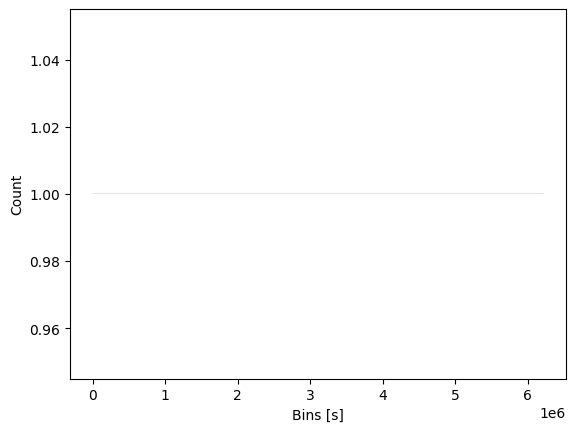

In [17]:
uniques_idx, counts_idx = np.unique(indices_digitized, return_counts=True)
plt.plot(bins[uniques_idx], counts_idx, 'g', linewidth=0.1)
plt.xlabel("Bins [s]")
plt.ylabel("Count")  # nb. data falling into bin
plt.show()

This above shows there's no need to average data falling into bins because there's is maximum one there.

In [18]:
np.unique(bins[uniques_idx]).size, bins.size

(64682, 103655)

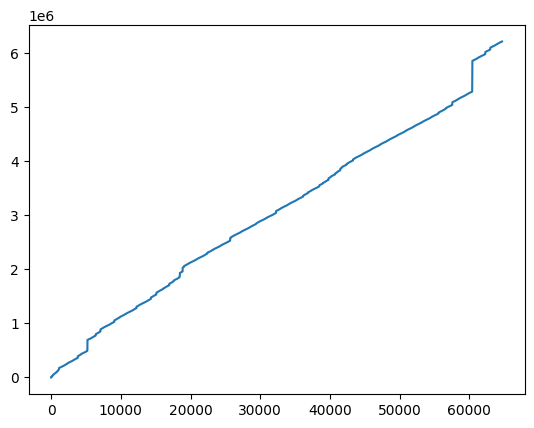

In [19]:
plt.plot(np.unique(bins[uniques_idx]))
plt.show()

However, there are **empty bins** !!

In [20]:
data_df.describe()

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,...,rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
count,64682.000000,64682.000000,64682.000000,64682.000000,64682.000000,64682.000000,64682.000000,64682.000000,6.468200e+04,64682.000000,...,64682.000000,64682.000000,64682.000000,6.468200e+04,64682.000000,64682.000000,64682.000000,64682.000000,6.468200e+04,64682.000000
mean,4362.710796,179.909775,9.933683,187.390251,27.468865,32.368153,4.528730,4.205896,1.486576e+09,6379.344238,...,10.723171,1.565940,0.072308,1.585182e+05,42842.988583,11495.852381,6767.852416,1928.185375,2.526032e+05,10056.048286
std,7048.901460,105.377543,29.171879,114.178519,37.821989,2.979160,109.655682,28.744569,1.648714e+06,4497.713867,...,4.544361,1.451365,0.321620,7.875762e+04,18916.588834,3008.324068,1767.136660,721.882986,1.259162e+05,2917.459228
min,0.000000,0.001536,-51.780590,0.002334,-86.673214,15.600000,-179.991849,-42.765346,1.483525e+09,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,680.072750,87.719069,-16.505383,75.428649,32.920924,30.000000,-100.546931,-22.321477,1.485178e+09,3307.000000,...,7.478017,0.000000,0.000000,1.303355e+05,33884.523275,9129.056799,5414.638907,1558.276501,1.935796e+05,7883.093655
50%,2012.169750,180.417892,12.371567,220.409236,39.118393,32.299999,20.630334,7.448405,1.486611e+09,4554.500000,...,10.142016,1.431948,0.000000,1.396940e+05,38603.668105,10659.510392,6301.603294,1791.833457,2.148173e+05,9228.393615
75%,4014.362250,271.839385,35.993074,283.994691,49.555842,34.299999,101.321960,31.533336,1.487928e+09,7488.000000,...,13.315553,2.413685,0.000000,1.572584e+05,45926.984152,13050.825644,7676.646489,2146.724478,2.613420e+05,11295.788389
max,65271.428000,359.993599,53.794792,359.998220,86.635762,39.000000,179.998087,42.764834,1.489745e+09,25630.000000,...,65.727023,11.077002,4.548821,1.958181e+06,983010.609637,69733.776778,40907.195110,31095.669848,2.602164e+06,96123.715419


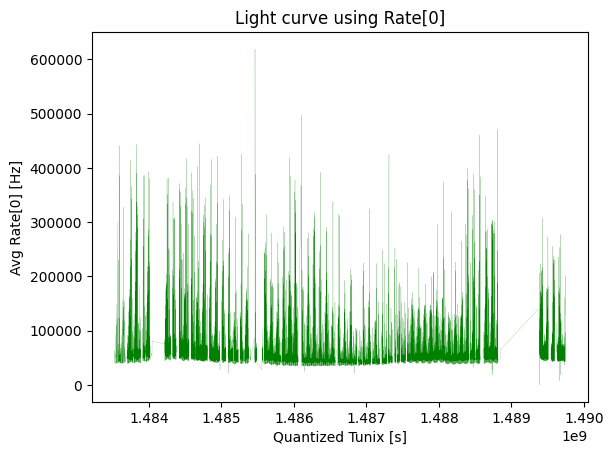

In [21]:
plt.plot(data_df[tunix_name], data_df[target_name], 'g', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel(f"Avg Rate[{i}] [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title(f"Light curve using Rate[{i}]")
plt.show()

Up to this point, our data is **not** at equidistant quantized times due to missing values/data

In [22]:
# Uncomment below if want to export the data into a CSV file
# import os  

# os.makedirs('../data', exist_ok=True)
# data_df.to_csv('../data/fmrate_dataset_binned.csv', index=False)  

In [23]:
import os  

os.makedirs('../data', exist_ok=True)
data_df.to_csv('../data/fmrate_dataset.csv', index=False)  

In [24]:
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,...,rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.599998,69.831172,41.997769,1.483525e+09,8323.0,...,9.175346,2.398795,0.000000,144902.177530,45712.324384,13845.953080,8356.903924,2438.513754,239474.841087,11744.694832
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.700001,74.831447,42.486682,1.483526e+09,7893.0,...,12.970488,0.977676,0.000000,153318.962241,48581.165475,14829.628152,8883.639889,2635.849803,253521.561985,12586.337166
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.799999,79.894200,42.732372,1.483526e+09,8616.0,...,22.955236,6.997275,1.440506,153940.468185,48497.795501,14516.429778,8760.980672,2490.574534,253464.050166,12447.241383
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.900002,84.978480,42.730839,1.483526e+09,7961.0,...,10.679009,0.000000,0.000000,153332.226326,48214.601357,14549.504555,8738.605590,2533.338163,253057.586337,12516.820358
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.000000,90.041732,42.481912,1.483526e+09,7857.0,...,10.958631,1.675759,0.000000,152311.547934,48175.919461,14699.423072,8731.916784,2473.908613,249121.718756,12395.476760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.299999,102.504047,-39.787169,1.489744e+09,19174.0,...,20.845726,0.000000,0.000000,421381.161376,91254.976413,18187.144117,10166.549068,2520.873146,675029.015069,17152.212729
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.299999,107.186486,-40.836773,1.489745e+09,21385.0,...,15.407485,0.498087,0.000000,493352.601640,91960.388522,18408.719222,10437.676092,2687.357262,787895.241321,17259.848070
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.400002,111.848502,-41.645589,1.489745e+09,22211.0,...,19.850554,3.139644,0.000000,381079.484260,80642.260970,19433.904554,10932.724402,2747.667543,648988.657261,17762.022693
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.400002,116.784951,-42.257397,1.489745e+09,23759.0,...,19.554150,1.672301,0.000000,339358.361808,78711.053376,20140.309630,11353.850287,2851.749516,594285.018883,18096.580711


In [25]:
corr = data_df.corr()

In [26]:
corr

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,...,rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
time_since_saa,1.000000,-0.016123,-0.014943,-0.021574,-0.056437,-0.035310,-0.025629,-0.002408,0.129891,-0.123445,...,-0.115288,-0.052188,-0.008060,-0.109560,-0.124578,-0.203094,-0.214072,-0.167164,-0.115478,-0.186441
raz,-0.016123,1.000000,0.040565,-0.175890,0.267840,-0.391651,-0.029270,-0.017659,-0.022333,0.017391,...,-0.035087,-0.017569,-0.007830,0.047528,0.019555,-0.015451,-0.022085,-0.013158,0.065606,0.020198
decz,-0.014943,0.040565,1.000000,-0.174004,0.022612,0.038125,-0.021730,0.966202,0.030380,-0.201017,...,-0.092354,-0.042283,-0.008657,-0.176789,-0.146042,-0.130458,-0.116541,-0.079501,-0.201563,-0.156654
rax,-0.021574,-0.175890,-0.174004,1.000000,0.239807,0.499479,0.017784,-0.230294,0.138497,-0.001894,...,0.044987,0.030233,0.010648,-0.007792,-0.004396,0.064587,0.077230,0.051360,-0.051967,0.016366
decx,-0.056437,0.267840,0.022612,0.239807,1.000000,0.030740,0.015357,-0.207660,0.162230,0.056662,...,0.064173,0.035167,0.011626,0.038280,0.053096,0.133897,0.143132,0.108593,0.024906,0.106244
temperature,-0.035310,-0.391651,0.038125,0.499479,0.030740,1.000000,-0.003427,0.018672,0.104274,-0.004938,...,0.096212,0.052094,0.013591,-0.072032,-0.037263,0.086617,0.098877,0.039314,-0.156964,-0.010879
glon,-0.025629,-0.029270,-0.021730,0.017784,0.015357,-0.003427,1.000000,-0.023536,-0.005938,0.050261,...,0.047585,0.025880,0.006601,0.002950,0.026426,0.087049,0.101013,0.088268,0.011124,0.071661
glat,-0.002408,-0.017659,0.966202,-0.230294,-0.207660,0.018672,-0.023536,1.000000,-0.010727,-0.224897,...,-0.115821,-0.054000,-0.012114,-0.192430,-0.169932,-0.173860,-0.160835,-0.110864,-0.214026,-0.193354
unix_time,0.129891,-0.022333,0.030380,0.138497,0.162230,0.104274,-0.005938,-0.010727,1.000000,0.012757,...,-0.008679,-0.003750,0.004084,-0.028281,-0.029147,-0.020594,-0.027188,-0.036847,-0.025552,-0.025524
fe_cosmic,-0.123445,0.017391,-0.201017,-0.001894,0.056662,-0.004938,0.050261,-0.224897,0.012757,1.000000,...,0.563780,0.241233,0.044884,0.524816,0.594860,0.856826,0.779553,0.422170,0.680441,0.868784


Text(0.5, 1.0, 'Correlation Matrix between types of measurements')

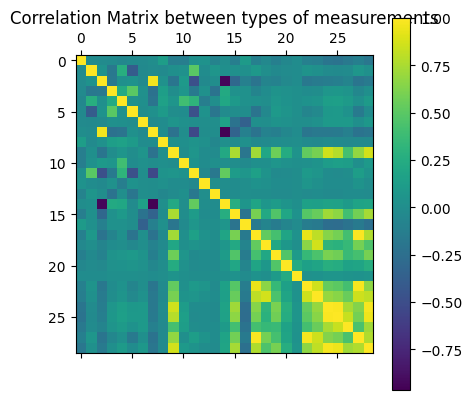

In [27]:
plt.matshow(corr)
plt.colorbar()

plt.title('Correlation Matrix between types of measurements')

In [28]:
corr[target_name]

time_since_saa   -0.112667
raz               0.081664
decz             -0.206622
rax              -0.078112
decx              0.019531
temperature      -0.212160
glon              0.015259
glat             -0.217072
unix_time        -0.028899
fe_cosmic         0.724257
is_orbit_up       0.010409
altitude          0.153309
sun               0.038158
sun_spot          0.000001
B_r               0.184330
B_theta           0.594078
B_phi            -0.159937
rate[0]           1.000000
rate[1]           0.530032
rate[2]           0.422951
rate[3]           0.180784
rate[4]           0.033834
rate[5]           0.931853
rate[6]           0.807855
rate[7]           0.646204
rate[8]           0.591879
rate[9]           0.410619
rate[10]          0.989445
rate[11]          0.763709
Name: rate[0], dtype: float64